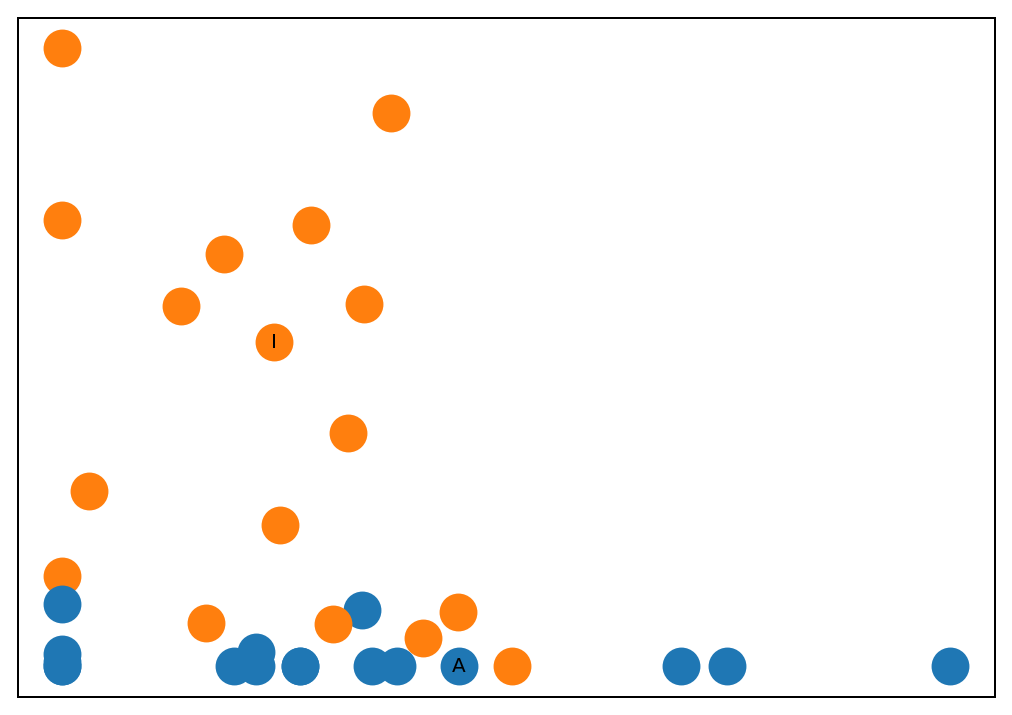

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# load karate network 
zkc = nx.karate_club_graph()
order = sorted(list(zkc.nodes()))

# input parameters
A = nx.to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=1))
D_hat = [x[0] for x in D_hat]
D_hat = np.matrix(np.diag(D_hat))

# initializing weight
W_1 = np.random.normal(loc=0, scale=1, size=(zkc.number_of_nodes(), 4))  # Normal Distribution or Gaussian Distribution
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))
# loc is Mean (“centre”) of the distribution
# scale is Standard deviation (spread or “width”) of the distribution
# size is Output shape

# GCN Model
def relu(x):
    return np.maximum(x, 0)

def gcn_layer(A, D, X, W):
    return relu(D**-1*A*X*W)

H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

# get feature representations of nodes
feature_representations = {node: np.array(output)[node] for node in zkc.nodes()}

# visualizing the features
plt.figure(figsize=(7, 5), dpi=180)  # set the size of the figure
pos = feature_representations
for x in zkc.nodes():
    if zkc.nodes[x]['club'] == 'Mr. Hi':
        nx.draw_networkx_nodes(zkc, pos, [x], node_size = 200, node_color = '#1f77b4', alpha=1)
        
    else:
        nx.draw_networkx_nodes(zkc, pos, [x], node_size = 200, node_color = '#ff7f0e', alpha=1) 

labels = {}
labels[0] = r'A'
labels[33] = r'I'
nx.draw_networkx_labels(zkc, pos, labels, font_size=8)
# plt.axis('off')
plt.show()

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import torch
from torch_geometric.data import InMemoryDataset, Data

# build a graph
G = nx.Graph()
edgelist = [(0, 1), (0, 2), (1, 3)]  
G.add_edges_from(edgelist)
x = torch.eye(G.number_of_nodes(), dtype=torch.float)
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# Compute communities.
partition = community_louvain.best_partition(G)
y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])

train_mask = torch.zeros(y.size(0), dtype=torch.bool)
for i in range(int(y.max()) + 1):
    train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)
remaining = (~data.train_mask).nonzero(as_tuple=False).view(-1)
remaining = remaining[torch.randperm(remaining.size(0))]
data.test_mask = torch.zeros(y.size(0), dtype=torch.bool)
data.test_mask.fill_(False)
data.test_mask[remaining[:]] = True

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)  

def train():
    optimizer.zero_grad()  
    out = model()
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

for epoch in range(1, 11):
    train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, *test()))


Epoch: 001, Train: 0.5000, Test: 1.0000
Epoch: 002, Train: 1.0000, Test: 1.0000
Epoch: 003, Train: 1.0000, Test: 1.0000
Epoch: 004, Train: 1.0000, Test: 1.0000
Epoch: 005, Train: 1.0000, Test: 1.0000
Epoch: 006, Train: 1.0000, Test: 1.0000
Epoch: 007, Train: 1.0000, Test: 1.0000
Epoch: 008, Train: 1.0000, Test: 1.0000
Epoch: 009, Train: 1.0000, Test: 1.0000
Epoch: 010, Train: 1.0000, Test: 1.0000


Epoch: 01, Loss: 8.1631, Acc: 0.1530
Epoch: 02, Loss: 6.1029, Acc: 0.1730
Epoch: 03, Loss: 4.9928, Acc: 0.2110
Epoch: 04, Loss: 4.1574, Acc: 0.2470
Epoch: 05, Loss: 3.5137, Acc: 0.2810
Epoch: 06, Loss: 2.9917, Acc: 0.3230
Epoch: 07, Loss: 2.5719, Acc: 0.3470
Epoch: 08, Loss: 2.2334, Acc: 0.3750
Epoch: 09, Loss: 1.9626, Acc: 0.3920
Epoch: 10, Loss: 1.7517, Acc: 0.4150
Epoch: 11, Loss: 1.5815, Acc: 0.4480
Epoch: 12, Loss: 1.4402, Acc: 0.4810
Epoch: 13, Loss: 1.3282, Acc: 0.5000
Epoch: 14, Loss: 1.2403, Acc: 0.5310
Epoch: 15, Loss: 1.1688, Acc: 0.5330
Epoch: 16, Loss: 1.1129, Acc: 0.5580
Epoch: 17, Loss: 1.0645, Acc: 0.5840
Epoch: 18, Loss: 1.0309, Acc: 0.6050
Epoch: 19, Loss: 1.0010, Acc: 0.6150
Epoch: 20, Loss: 0.9754, Acc: 0.6250
Epoch: 21, Loss: 0.9566, Acc: 0.6400
Epoch: 22, Loss: 0.9392, Acc: 0.6490
Epoch: 23, Loss: 0.9245, Acc: 0.6540
Epoch: 24, Loss: 0.9138, Acc: 0.6610
Epoch: 25, Loss: 0.9052, Acc: 0.6660
Epoch: 26, Loss: 0.8949, Acc: 0.6720
Epoch: 27, Loss: 0.8902, Acc: 0.6790
E

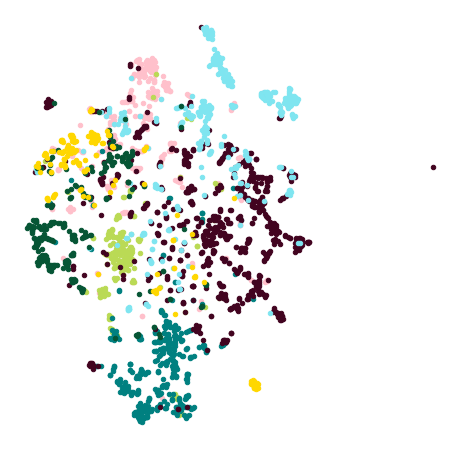

In [5]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)